In [78]:
import warnings                                                   
warnings.filterwarnings('ignore')     
import pandas as pd       
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import xarray as xr
import arviz as az
import watermark
from scipy.special import expit as logistic


from manager_db import *

print(os.getcwd())
print(sys.argv[0])
print(os.path.dirname(os.path.realpath('__file__')))

/Users/marcelino/dmarcelinobr/pollingpoint
/Users/marcelino/opt/anaconda3/envs/pp-env/lib/python3.8/site-packages/ipykernel_launcher.py
/Users/marcelino/dmarcelinobr/pollingpoint


In [272]:
# hide
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
plt.style.use('ggplot')
az.style.use("arviz-darkgrid")

%load_ext watermark
%watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2021-06-17T22:37:42.117647-03:00

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 7.22.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 19.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit



## Conexão com o banco de dados

con = sqlite3.connect('pollingpoint.db')

cursor = con.cursor()

cursor.execute("""
UPDATE aprovacao 
SET nome = 'Atlas'
WHERE nome = 'Atlas Político';
""")


# gravando no bd
con.commit()

print('Dados atualizados com sucesso.')

con.close()

In [179]:
con = sqlite3.connect('pollingpoint.db')


file_long = pd.read_sql(""" SELECT * FROM intencao;""", con=con) 

con.close()

file_long

,id,data_ini,data_fim,empresa,nome,cargo,turno,partido,candidato,voto,erro,ic,amostra,ufs,cidades,tipo,modo,pergunta,timestamp
0,1,2020-12-21,2020-12-23,PoderData,PoderData/Poder360,Presidente,1,(Sem partido),Jair Bolsonaro,36.0,2.0,95,2500,27.0,545.0,Intenção,IVR,Em 2022 teremos eleição para presidente do Bra...,2021-06-11 09:19:00
1,2,2020-12-21,2020-12-23,PoderData,PoderData/Poder360,Presidente,1,None,NS/NR,5.0,2.0,95,2500,27.0,545.0,Intenção,IVR,Em 2022 teremos eleição para presidente do Bra...,2021-06-11 09:19:00
2,3,2020-12-21,2020-12-23,PoderData,PoderData/Poder360,Presidente,1,PC do B,Flavio Dino,1.0,2.0,95,2500,27.0,545.0,Intenção,IVR,Em 2022 teremos eleição para presidente do Bra...,2021-06-11 09:19:00
3,4,2020-12-21,2020-12-23,PoderData,PoderData/Poder360,Presidente,1,DEM,Henrique Mandetta,1.0,2.0,95,2500,27.0,545.0,Intenção,IVR,Em 2022 teremos eleição para presidente do Bra...,2021-06-11 09:19:00
4,5,2020-12-21,2020-12-23,PoderData,PoderData/Poder360,Presidente,1,PSDB,João Doria,3.0,2.0,95,2500,27.0,545.0,Intenção,IVR,Em 2022 teremos eleição para presidente do Bra...,2021-06-11 09:19:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,347,2021-03-08,2021-03-10,Atlas,Atlas,Presidente,1,PRTB,Hamilton Mourão,25.0,3.0,95,3721,27,None,Potencial neutro,Online,Você tem uma imagem positiva ou negativa desse...,2021-06-17 12:55:08
347,348,2021-03-08,2021-03-10,Atlas,Atlas,Presidente,1,PRTB,Hamilton Mourão,43.0,3.0,95,3721,27,None,Potencial negativo,Online,Você tem uma imagem positiva ou negativa desse...,2021-06-17 12:55:08
348,349,2021-03-08,2021-03-10,Atlas,Atlas,Presidente,1,(Sem partido),Paulo Guedes,34.0,3.0,95,3721,27,None,Potencial positivo,Online,Você tem uma imagem positiva ou negativa desse...,2021-06-17 12:55:08
349,350,2021-03-08,2021-03-10,Atlas,Atlas,Presidente,1,(Sem partido),Paulo Guedes,15.0,3.0,95,3721,27,None,Potencial neutro,Online,Você tem uma imagem positiva ou negativa desse...,2021-06-17 12:55:08


In [81]:
file_long.groupby(by=['data_ini', 'data_fim', 'empresa'],as_index=False).count()

,data_ini,data_fim,empresa,id,nome,cargo,turno,partido,candidato,voto,erro,ic,amostra,ufs,cidades,tipo,modo,pergunta,timestamp
0,2020-08-24,2020-08-31,IDEIA,20,20,20,20,14,20,20,20,20,20,20,0,20,20,20,20
1,2020-12-21,2020-12-23,PoderData,11,11,11,11,9,11,11,11,11,11,11,11,11,11,11,11
2,2021-02-25,2021-03-01,Paraná,10,10,10,10,8,10,10,10,10,10,10,10,10,10,10,10
3,2021-03-08,2021-03-10,Atlas,80,80,80,80,71,80,80,80,80,80,80,0,80,80,80,80
4,2021-03-15,2021-03-17,PoderData,20,20,20,20,19,20,20,20,20,20,20,20,20,20,20,20
5,2021-04-12,2021-04-14,PoderData,38,38,38,38,36,38,38,38,38,38,38,38,38,38,38,38
6,2021-04-21,2021-04-22,IDEIA,10,10,10,10,8,10,10,10,10,10,0,0,10,10,10,10
7,2021-05-10,2021-05-12,PoderData,9,9,9,9,7,9,9,9,9,9,9,9,9,9,9,9
8,2021-06-01,2021-06-04,Ipespe,3,3,3,3,0,3,3,3,3,3,3,0,3,3,3,3
9,2021-06-01,2021-06-04,Ranking Brasil,75,75,75,75,62,75,75,75,75,75,75,75,75,75,75,75


In [82]:
file_long.groupby(by=['candidato'],as_index=False).count()

,candidato,id,data_ini,data_fim,empresa,nome,cargo,turno,partido,voto,erro,ic,amostra,ufs,cidades,tipo,modo,pergunta,timestamp
0,Alexandre Kalil,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1
1,Branco/Nulo,11,11,11,11,11,11,11,1,11,11,11,11,10,6,11,11,11,11
2,Branco/Nulo/NS/NR,30,30,30,30,30,30,30,0,30,30,30,30,30,13,30,30,30,30
3,Ciro Gomes,29,29,29,29,29,29,29,29,29,29,29,29,28,19,29,29,29,29
4,Danilo Gentili,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1
5,Fernando Haddad,7,7,7,7,7,7,7,7,7,7,7,7,7,2,7,7,7,7
6,Flavio Dino,6,6,6,6,6,6,6,6,6,6,6,6,6,1,6,6,6,6
7,Guilherme Boulos,10,10,10,10,10,10,10,10,10,10,10,10,10,6,10,10,10,10
8,Hamilton Mourão,3,3,3,3,3,3,3,3,3,3,3,3,3,0,3,3,3,3
9,Henrique Mandetta,18,18,18,18,18,18,18,18,18,18,18,18,17,9,18,18,18,18


In [83]:
file_long.groupby(by=['tipo'],as_index=False).count()

,tipo,id,data_ini,data_fim,empresa,nome,cargo,turno,partido,candidato,voto,erro,ic,amostra,ufs,cidades,modo,pergunta,timestamp
0,,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1
1,Bolsonaro x Boulos,3,3,3,3,3,3,3,2,3,3,3,3,3,3,0,3,3,3
2,Bolsonaro x Ciro,11,11,11,11,11,11,11,9,11,11,11,11,11,11,5,11,11,11
3,Bolsonaro x Doria,12,12,12,12,12,12,12,10,12,12,12,12,12,12,6,12,12,12
4,Bolsonaro x Haddad,3,3,3,3,3,3,3,2,3,3,3,3,3,3,0,3,3,3
5,Bolsonaro x Huck,12,12,12,12,12,12,12,10,12,12,12,12,12,12,6,12,12,12
6,Bolsonaro x Lula,19,19,19,19,19,19,19,14,19,19,19,19,19,19,9,19,19,19
7,Bolsonaro x Mandetta,3,3,3,3,3,3,3,2,3,3,3,3,3,3,0,3,3,3
8,Bolsonaro x Marina,3,3,3,3,3,3,3,2,3,3,3,3,3,3,0,3,3,3
9,Bolsonaro x Moro,14,14,14,14,14,14,14,10,14,14,14,14,14,14,4,14,14,14


In [84]:
# file_long1t = file_long.loc[(file_long['turno'] == 1) & (file_long['tipo'] == 'Intenção')]

file_long1t = file_long[file_long['turno'] == 1]

file_long2t = file_long[file_long['turno'] == 2]


In [85]:

file_long1t.pivot_table(index=["data_fim","empresa", "turno", "modo"], 
                    columns='candidato', 
                    values='voto',
                    margins=True,  # add margins
                    aggfunc='mean')  # sum margins (rows/columns)


,,,candidato,Alexandre Kalil,Branco/Nulo,Branco/Nulo/NS/NR,Ciro Gomes,Danilo Gentili,Fernando Haddad,Flavio Dino,Guilherme Boulos,Hamilton Mourão,Henrique Mandetta,...,Luciano Huck,Lula,Marina Silva,Michel Temer,NS/NR,Outros,Paulo Guedes,Rodrigo Maia,Sérgio Moro,All
data_fim,empresa,turno,modo,,,,,,,,,,,,,,,,,,,,,
2020-08-31,IDEIA,1,CATI,NaN,7.000000,NaN,6.000000,NaN,NaN,1.000000,NaN,NaN,4.000000,...,5.000000,17.000000,2.00000,NaN,7.0,NaN,NaN,NaN,13.000000,8.250000
2020-12-23,PoderData,1,IVR,NaN,7.000000,NaN,NaN,NaN,13.000000,1.000000,5.000000,NaN,1.000000,...,9.000000,NaN,NaN,NaN,5.0,NaN,NaN,NaN,7.000000,8.181818
2021-03-01,Paraná,1,CATI,NaN,12.500000,NaN,10.000000,NaN,10.500000,NaN,3.200000,NaN,NaN,...,8.000000,NaN,NaN,NaN,4.3,NaN,NaN,NaN,11.500000,10.000000
2021-03-10,Atlas,1,Online,0.7,NaN,6.100000,26.875000,NaN,33.333333,25.175000,0.900000,33.333333,26.100000,...,25.625000,31.100000,25.32500,NaN,NaN,NaN,33.333333,33.333333,27.425000,27.221818
2021-03-17,PoderData,1,IVR,NaN,10.000000,NaN,5.000000,NaN,NaN,NaN,NaN,NaN,2.000000,...,4.000000,34.000000,NaN,NaN,3.0,NaN,NaN,NaN,6.000000,10.000000
2021-04-14,PoderData,1,IVR,NaN,7.000000,NaN,25.000000,NaN,NaN,NaN,NaN,NaN,2.000000,...,25.000000,32.500000,NaN,NaN,2.0,NaN,NaN,NaN,25.250000,24.107143
2021-04-22,IDEIA,1,CATI,NaN,4.000000,NaN,9.000000,2.0,NaN,NaN,NaN,NaN,3.000000,...,6.000000,33.000000,NaN,NaN,5.0,NaN,NaN,NaN,NaN,10.100000
2021-05-12,PoderData,1,IVR,NaN,8.000000,NaN,6.000000,NaN,NaN,NaN,NaN,NaN,3.000000,...,6.000000,32.000000,NaN,NaN,2.0,NaN,NaN,NaN,NaN,10.888889
2021-06-04,Ipespe,1,CATI,NaN,8.000000,15.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,19.666667


In [87]:

file_wide = file_long1t.pivot_table(index=["data_fim", "empresa", "turno", "modo", "tipo"], 
                    columns='candidato', 
                    values='voto')
                    

In [88]:
# Tabela pronta para análise:
file_wide.query("tipo == 'Intenção'")


,,,,candidato,Alexandre Kalil,Branco/Nulo,Branco/Nulo/NS/NR,Ciro Gomes,Danilo Gentili,Fernando Haddad,Flavio Dino,Guilherme Boulos,Hamilton Mourão,Henrique Mandetta,...,João Doria,Luciano Huck,Lula,Marina Silva,Michel Temer,NS/NR,Outros,Paulo Guedes,Rodrigo Maia,Sérgio Moro
data_fim,empresa,turno,modo,tipo,,,,,,,,,,,,,,,,,,,,,
2020-08-31,IDEIA,1,CATI,Intenção,NaN,7.0,NaN,6.00,NaN,NaN,1.0,NaN,NaN,4.0,...,3.00,5.00,17.00,2.0,NaN,7.0,NaN,NaN,NaN,13.00
2020-12-23,PoderData,1,IVR,Intenção,NaN,7.0,NaN,NaN,NaN,13.0,1.0,5.00,NaN,1.0,...,3.00,9.00,NaN,NaN,NaN,5.0,NaN,NaN,NaN,7.00
2021-03-01,Paraná,1,CATI,Intenção,NaN,12.5,NaN,10.00,NaN,10.5,NaN,3.20,NaN,NaN,...,5.30,8.00,NaN,NaN,NaN,4.3,NaN,NaN,NaN,11.50
2021-03-10,Atlas,1,Online,Intenção,0.7,NaN,6.10,7.50,NaN,NaN,0.7,0.90,NaN,4.4,...,4.30,2.50,24.40,1.3,NaN,NaN,NaN,NaN,NaN,9.70
2021-03-17,PoderData,1,IVR,Intenção,NaN,10.0,NaN,5.00,NaN,NaN,NaN,NaN,NaN,2.0,...,3.00,4.00,34.00,NaN,NaN,3.0,NaN,NaN,NaN,6.00
2021-04-14,PoderData,1,IVR,Intenção,NaN,7.0,NaN,6.00,NaN,NaN,NaN,NaN,NaN,2.0,...,4.00,6.00,34.00,NaN,NaN,2.0,NaN,NaN,NaN,3.00
2021-04-22,IDEIA,1,CATI,Intenção,NaN,4.0,NaN,9.00,2.0,NaN,NaN,NaN,NaN,3.0,...,4.00,6.00,33.00,NaN,NaN,5.0,NaN,NaN,NaN,NaN
2021-05-12,PoderData,1,IVR,Intenção,NaN,8.0,NaN,6.00,NaN,NaN,NaN,NaN,NaN,3.0,...,4.00,6.00,32.00,NaN,NaN,2.0,NaN,NaN,NaN,NaN
2021-06-04,Ipespe,1,CATI,Intenção,NaN,NaN,15.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [296]:

file_long = file_long[['data_fim', 'empresa', 'cargo', 'turno', 'candidato', 'voto', 'erro', 'amostra', 'tipo', 'modo']]

# converte 'data_fim' para o formato datetime 
file_long = file_long.query("tipo == 'Intenção' & turno==1")

# converte 'data_fim' para o formato datetime 
file_long['day']= file_long['data_fim'].astype('datetime64[ns]')
file_long['month'] = file_long['day'].dt.month
file_long['year'] = file_long['day'].dt.year

data = file_long.pivot_table(index=['day','month', 'year', 'empresa', 'turno', 'tipo', 'modo', 'amostra'], 
                    columns=['candidato'], 
                    values='voto').reset_index()

data.set_index('day', inplace=True)

POLLSTERS = data["empresa"].sort_values().unique()
comment = f"""A base de pesquisas contaim {len(data)} pesquisas realizadas entre {data["year"].min()} e {data["year"].max()}.
Existem {len(POLLSTERS)} empresas de pesquisa: {', '.join(list(POLLSTERS))}
"""
print(comment)

data

A base de pesquisas contaim 12 pesquisas realizadas entre 2020 e 2021.
Existem 6 empresas de pesquisa: Atlas, IDEIA, Ipespe, Paraná, PoderData, Ranking Brasil



candidato,month,year,empresa,turno,tipo,modo,amostra,Alexandre Kalil,Branco/Nulo,Branco/Nulo/NS/NR,...,Henrique Mandetta,Jair Bolsonaro,João Amoêdo,João Doria,Luciano Huck,Lula,Marina Silva,Michel Temer,NS/NR,Sérgio Moro
day,,,,,,,,,,,,,,,,,,,,,
2020-08-31,8,2020,IDEIA,1,Intenção,CATI,1235,NaN,7.0,NaN,...,4.0,31.00,3.00,3.00,5.00,17.00,2.0,NaN,7.0,13.00
2020-12-23,12,2020,PoderData,1,Intenção,IVR,2500,NaN,7.0,NaN,...,1.0,36.00,3.00,3.00,9.00,NaN,NaN,NaN,5.0,7.00
2021-03-01,3,2021,Paraná,1,Intenção,CATI,2080,NaN,12.5,NaN,...,NaN,31.90,2.80,5.30,8.00,NaN,NaN,NaN,4.3,11.50
2021-03-10,3,2021,Atlas,1,Intenção,Online,3721,0.7,NaN,6.10,...,4.4,32.70,2.00,4.30,2.50,24.40,1.3,NaN,NaN,9.70
2021-03-17,3,2021,PoderData,1,Intenção,IVR,3500,NaN,10.0,NaN,...,2.0,30.00,3.00,3.00,4.00,34.00,NaN,NaN,3.0,6.00
2021-04-14,4,2021,PoderData,1,Intenção,IVR,3500,NaN,7.0,NaN,...,2.0,31.00,5.00,4.00,6.00,34.00,NaN,NaN,2.0,3.00
2021-04-22,4,2021,IDEIA,1,Intenção,CATI,1200,NaN,4.0,NaN,...,3.0,32.00,3.00,4.00,6.00,33.00,NaN,NaN,5.0,NaN
2021-05-12,5,2021,PoderData,1,Intenção,IVR,2500,NaN,8.0,NaN,...,3.0,32.00,5.00,4.00,6.00,32.00,NaN,NaN,2.0,NaN
2021-06-04,6,2021,Ipespe,1,Intenção,CATI,1000,NaN,NaN,15.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [248]:

def dates_to_idx(timelist):
    """Convert datetimes to numbers in reference to a given date"""

    reference_time = timelist[0]
    t = (timelist - reference_time) / np.timedelta64(1, "M")

    return np.asarray(t)


time = dates_to_idx(data.index)
time[:10]


array([0.        , 3.74545679, 5.9795889 , 6.27528286, 6.50526705,
       7.4252038 , 7.68804288, 8.34514056, 9.10080289, 9.10080289])

In [249]:
def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

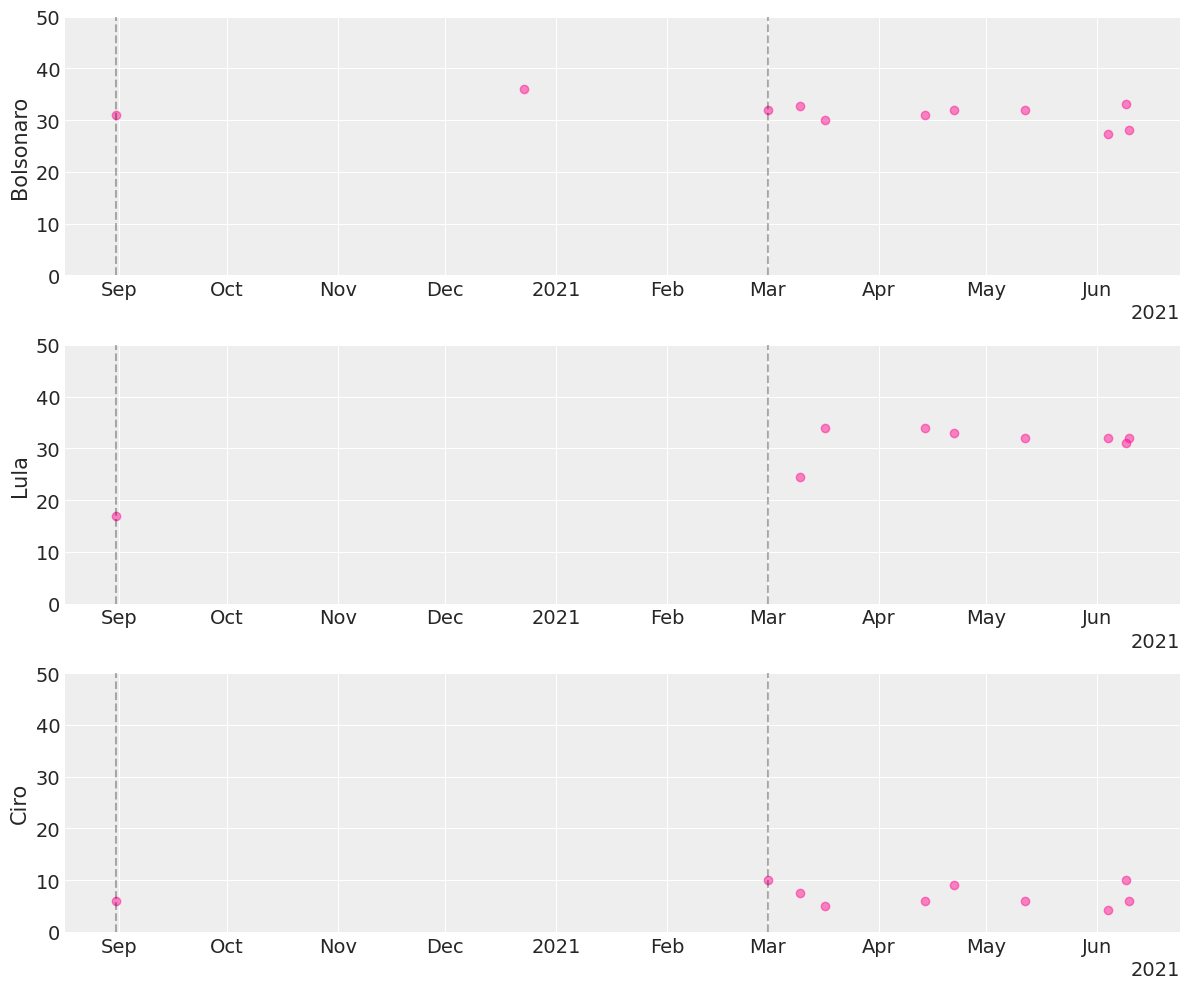

In [312]:

bolsonaro_rates = data["Jair Bolsonaro"].values
lula_rates = data["Lula"].values
ciro_rates = data["Ciro Gomes"].values

other_rates = 100 - bolsonaro_rates - lula_rates - ciro_rates

newterm_dates = data.reset_index().groupby("year").first()["day"].values
dates = data.index

fig, axes = plt.subplots(3, figsize=(12, 10))
for ax, rate, label in zip(
    axes.ravel(),
    [bolsonaro_rates, lula_rates, ciro_rates],
    ["Bolsonaro", "Lula", "Ciro"],
):
    ax.plot(dates, rate, "o", alpha=0.5, color="deeppink")
    ax.set_ylim(0, 50)
    ax.set_ylabel(label)
    locator = mdates.AutoDateLocator()
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter) 

    for date in newterm_dates:
        ax.axvline(date, color="k", alpha=0.3, linestyle="--")
        fig.tight_layout();


In [313]:
rolling_std = (
    data.reset_index()
    .groupby(["year", "month"])
    .std()
    .reset_index()[["year", "month", "Lula"]]
)
rolling_std



candidato,year,month,Lula
0,2020,8,NaN
1,2020,12,NaN
2,2021,3,6.788225
3,2021,4,0.707107
4,2021,5,NaN
5,2021,6,0.598582


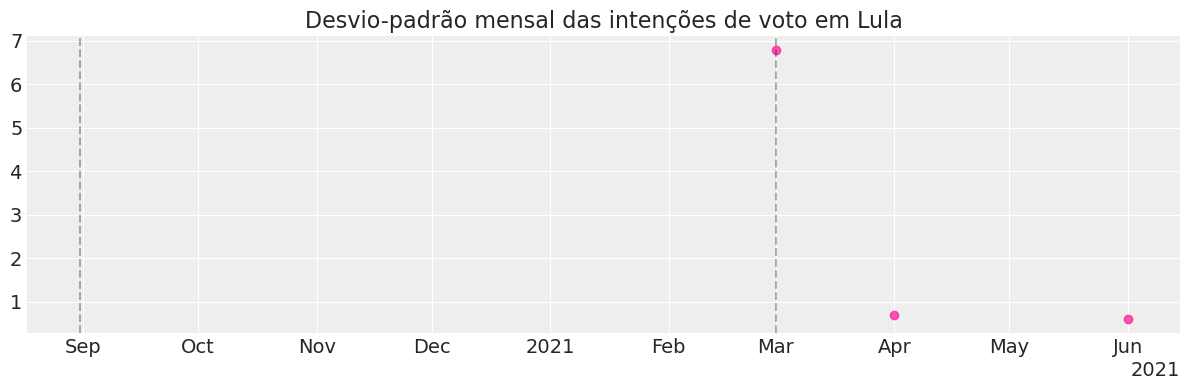

In [314]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(
    pd.to_datetime(
        [f"{y}-{m}-01" for y, m in zip(rolling_std.year, rolling_std.month)]
    ),
    rolling_std.Lula.values,
    "o",
   color="deeppink",
    alpha=0.7,
)

ax.set_title("Desvio-padrão mensal das intenções de voto em Lula")
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

for date in newterm_dates:
    ax.axvline(date, color="k", alpha=0.3, linestyle="--")
    fig.tight_layout();

In [316]:
rolling_std = (
    data.reset_index()
    .groupby(["year", "month"])
    .std()
    .reset_index()[["year", "month", "Jair Bolsonaro"]]
)

rolling_std.rename(columns = {'Jair Bolsonaro':'Bolsonaro'}, inplace = True)

rolling_std

candidato,year,month,Bolsonaro
0,2020,8,NaN
1,2020,12,NaN
2,2021,3,1.386843
3,2021,4,0.707107
4,2021,5,NaN
5,2021,6,3.098328


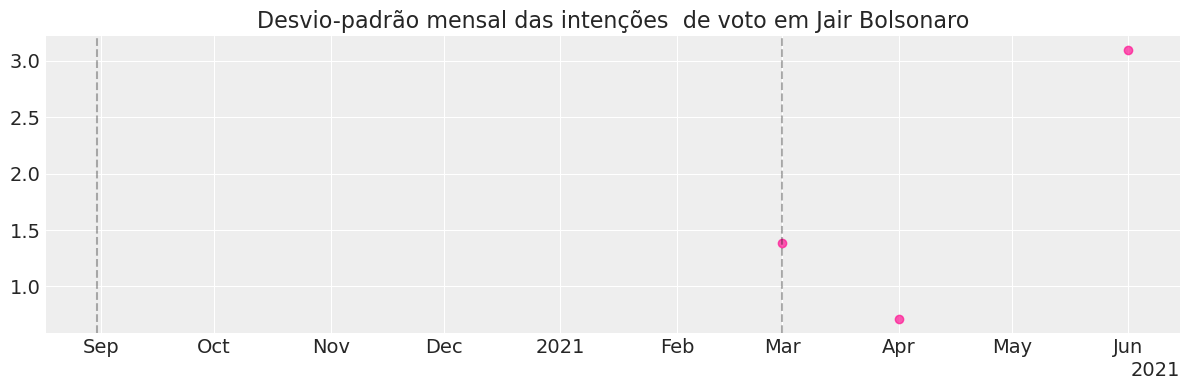

In [317]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(
    pd.to_datetime(
        [f"{y}-{m}-01" for y, m in zip(rolling_std.year, rolling_std.month)]
    ),
    rolling_std.Bolsonaro.values,
    "o",
    color="deeppink",
    alpha=0.7,
)

ax.set_title("Desvio-padrão mensal das intenções  de voto em Jair Bolsonaro")
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

for date in newterm_dates:
    ax.axvline(date, color="k", alpha=0.3, linestyle="--")
    fig.tight_layout();

In [318]:
rolling_std = (
    data.reset_index()
    .groupby(["year", "month"])
    .std()
    .reset_index()[["year", "month", "Ciro Gomes"]]
)

rolling_std.rename(columns = {'Ciro Gomes':'Ciro'}, inplace = True)

rolling_std

candidato,year,month,Ciro
0,2020,8,NaN
1,2020,12,NaN
2,2021,3,2.500000
3,2021,4,2.121320
4,2021,5,NaN
5,2021,6,2.913698


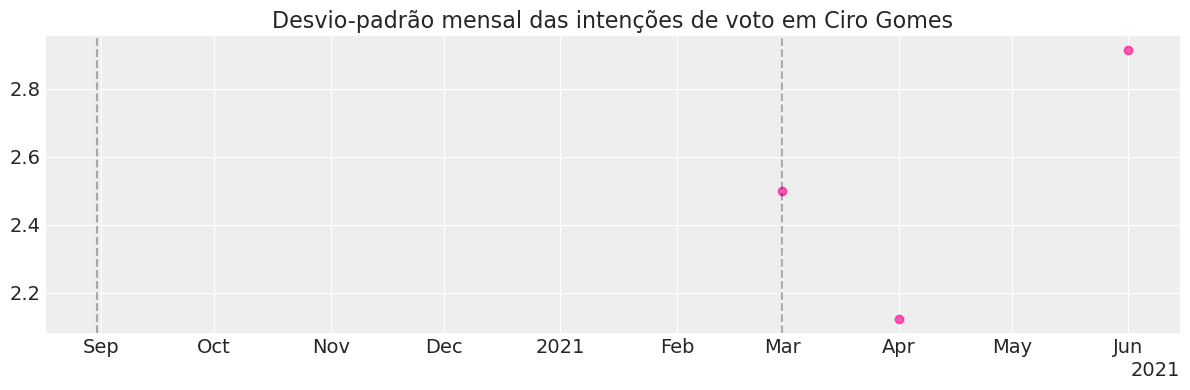

In [319]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(
    pd.to_datetime(
        [f"{y}-{m}-01" for y, m in zip(rolling_std.year, rolling_std.month)]
    ),
    rolling_std.Ciro.values,
    "o",
    color="deeppink",
    alpha=0.7,
)

ax.set_title("Desvio-padrão mensal das intenções de voto em Ciro Gomes")
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

for date in newterm_dates:
    ax.axvline(date, color="k", alpha=0.3, linestyle="--")
    fig.tight_layout();



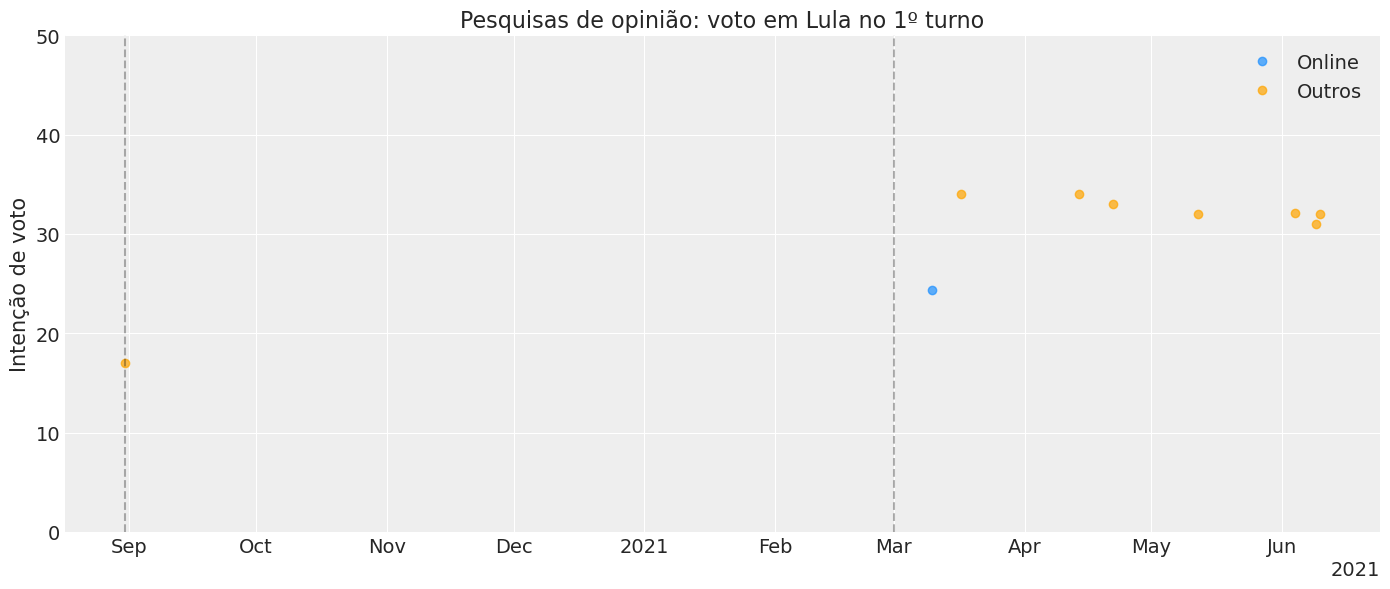

In [320]:
face = data[data["modo"] == "Online"]
dates_face = face.index

other = data[data["modo"] != "Online"]
dates_other = other.index

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(dates_face, face["Lula"].values, "o", alpha=0.7, label="Online", color="dodgerblue")
ax.plot(dates_other, other["Lula"].values, "o", alpha=0.7, label="Outros", color="orange")
ax.set_ylim(0, 50)
ax.set_ylabel("Intenção de voto")
ax.set_title("Pesquisas de opinião: voto em Lula no 1º turno")
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.legend()

for date in newterm_dates:
    ax.axvline(date, color="k", alpha=0.3, linestyle="--")
    fig.tight_layout();

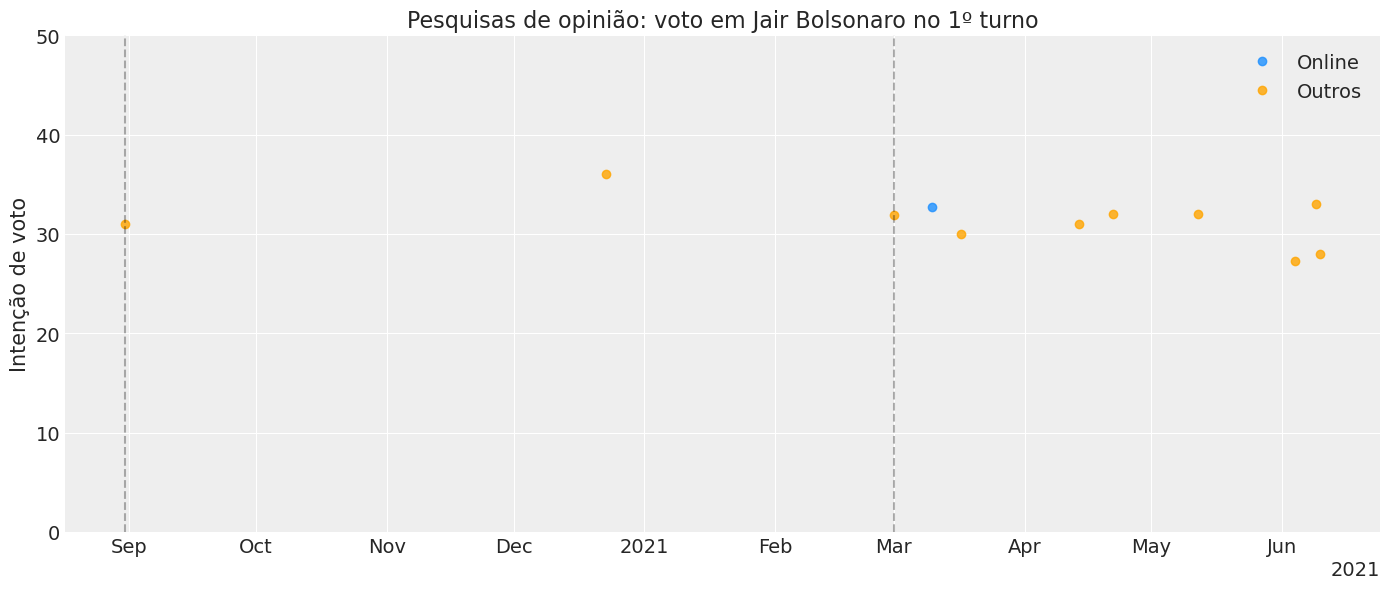

In [321]:
import matplotlib.dates as mdates
face = data[data["modo"] == "Online"]
dates_face = face.index

other = data[data["modo"] != "Online"]
dates_other = other.index

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(dates_face, face["Jair Bolsonaro"].values, "o", alpha=0.8, label="Online", color="dodgerblue")
ax.plot(dates_other, other["Jair Bolsonaro"].values, "o", alpha=0.8, label="Outros", color="orange")
ax.set_ylim(0, 50)
ax.set_ylabel("Intenção de voto")
ax.set_title("Pesquisas de opinião: voto em Jair Bolsonaro no 1º turno")
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.legend()

for date in newterm_dates:
    ax.axvline(date, color="k", alpha=0.3, linestyle="--")
    fig.tight_layout();

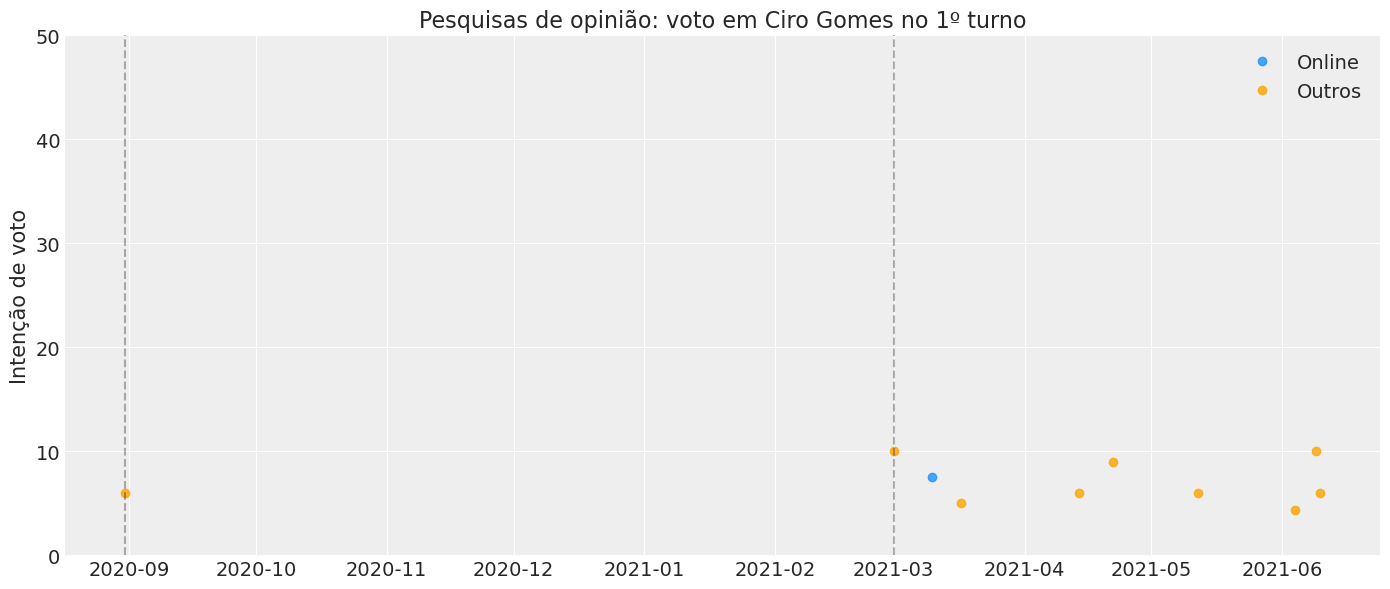

In [305]:
face = data[data["modo"] == "Online"]
dates_face = face.index

other = data[data["modo"] != "Online"]
dates_other = other.index

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(dates_face, face["Ciro Gomes"].values, "o", alpha=0.8, label="Online", color="dodgerblue")
ax.plot(dates_other, other["Ciro Gomes"].values, "o", alpha=0.8, label="Outros", color="orange")
ax.set_ylim(0, 50)
ax.set_ylabel("Intenção de voto")
ax.set_title("Pesquisas de opinião: voto em Ciro Gomes no 1º turno")
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.legend()

for date in newterm_dates:
    ax.axvline(date, color="k", alpha=0.3, linestyle="--")
    fig.tight_layout();

In [323]:
data = (
    data.reset_index()
    .merge(
        data.groupby(["year", "month"])["Jair Bolsonaro", "Lula", "Ciro Gomes"].mean().reset_index(),
        on=["year", "month"],
        suffixes=["", "_mean"],
    )
    .rename(columns={"index": "day"})
)
data["diff_Jair Bolsonaro"] = data["Jair Bolsonaro"] - data["Jair Bolsonaro_mean"]
data["diff_Lula"] = data["Lula"] - data["Lula_mean"]
data["diff_Ciro Gomes"] = data["Ciro Gomes"] - data["Ciro Gomes_mean"]


data.round(1)

candidato,day,month,year,empresa,turno,tipo,modo,amostra,Alexandre Kalil,Branco/Nulo,...,Marina Silva,Michel Temer,NS/NR,Sérgio Moro,Jair Bolsonaro_mean,Lula_mean,Ciro Gomes_mean,diff_Jair Bolsonaro,diff_Lula,diff_Ciro Gomes
0,2020-08-31,8,2020,IDEIA,1,Intenção,CATI,1235,NaN,7.0,...,2.0,NaN,7.0,13.0,31.0,17.0,6.0,0.0,0.0,0.0
1,2020-12-23,12,2020,PoderData,1,Intenção,IVR,2500,NaN,7.0,...,NaN,NaN,5.0,7.0,36.0,NaN,NaN,0.0,NaN,NaN
2,2021-03-01,3,2021,Paraná,1,Intenção,CATI,2080,NaN,12.5,...,NaN,NaN,4.3,11.5,31.5,29.2,7.5,0.4,NaN,2.5
3,2021-03-10,3,2021,Atlas,1,Intenção,Online,3721,0.7,NaN,...,1.3,NaN,NaN,9.7,31.5,29.2,7.5,1.2,-4.8,0.0
4,2021-03-17,3,2021,PoderData,1,Intenção,IVR,3500,NaN,10.0,...,NaN,NaN,3.0,6.0,31.5,29.2,7.5,-1.5,4.8,-2.5
5,2021-04-14,4,2021,PoderData,1,Intenção,IVR,3500,NaN,7.0,...,NaN,NaN,2.0,3.0,31.5,33.5,7.5,-0.5,0.5,-1.5
6,2021-04-22,4,2021,IDEIA,1,Intenção,CATI,1200,NaN,4.0,...,NaN,NaN,5.0,NaN,31.5,33.5,7.5,0.5,-0.5,1.5
7,2021-05-12,5,2021,PoderData,1,Intenção,IVR,2500,NaN,8.0,...,NaN,NaN,2.0,NaN,32.0,32.0,6.0,0.0,0.0,0.0
8,2021-06-04,6,2021,Ipespe,1,Intenção,CATI,1000,NaN,NaN,...,NaN,NaN,NaN,NaN,29.4,31.7,6.8,NaN,NaN,NaN
9,2021-06-04,6,2021,Ranking Brasil,1,Intenção,CATI,3000,NaN,NaN,...,1.1,1.7,NaN,4.1,29.4,31.7,6.8,-2.1,0.4,-2.4


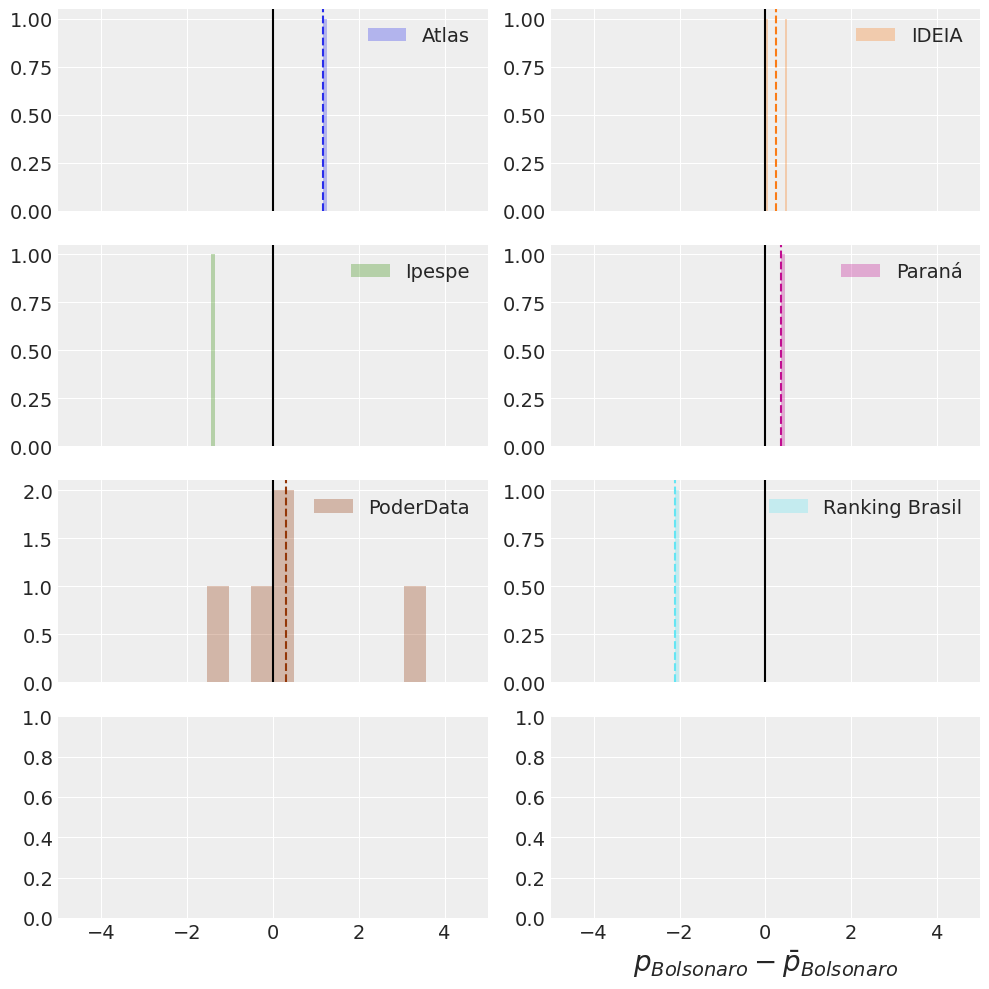

In [324]:
POLLSTER_VALS = {
    pollster: data[data["empresa"] == pollster]["diff_Jair Bolsonaro"].values
    for pollster in list(POLLSTERS)
}


colors = plt.rcParams["axes.prop_cycle"]()
fig, axes = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(10, 10))

for ax, (pollster, vals) in zip(axes.ravel(), POLLSTER_VALS.items()):
    c = next(colors)["color"]
    ax.hist(vals, alpha=0.3, color=c, label=pollster)
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")
    ax.axvline(x=0, color="black")
    ax.set_xlim(-5, 5)
    ax.legend()
   
plt.xlabel(r"$p_{Bolsonaro} - \bar{p}_{Bolsonaro}$", fontsize=20)
fig.tight_layout();


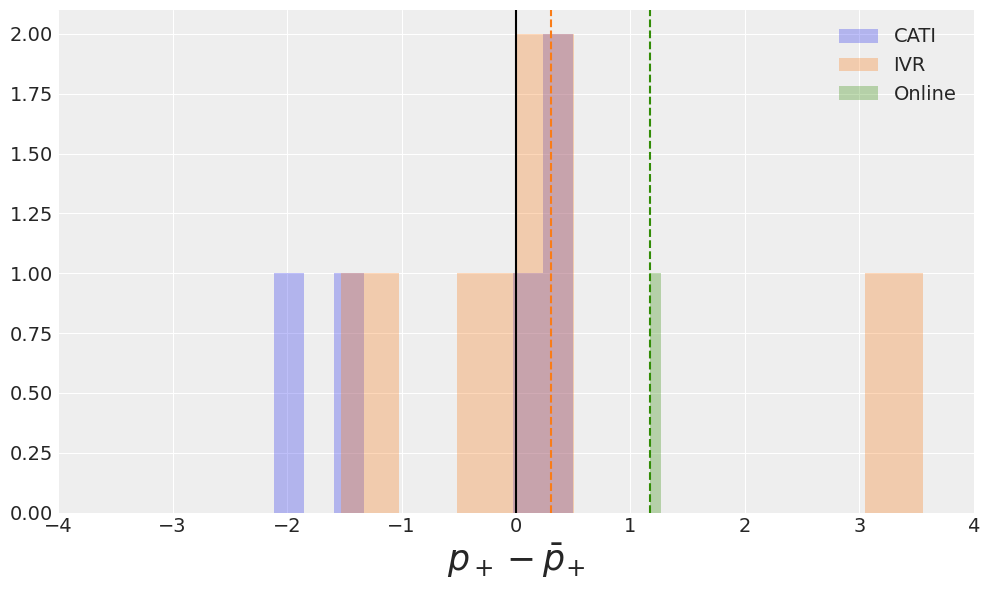

In [327]:
METHOD_VALS = {
    method: data[data["modo"] == method]["diff_Jair Bolsonaro"].values
    for method in list(data["modo"].unique())
}

colors = plt.rcParams["axes.prop_cycle"]()
fig, ax = plt.subplots(figsize=(10, 6))

for method, vals in METHOD_VALS.items():
    c = next(colors)["color"]
    ax.hist(vals, alpha=0.3, color=c, label=method)
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")

ax.axvline(x=0, color="black")
ax.set_xlim(-4, 4)
ax.set_xlabel(r"$p_+ - \bar{p}_{+}$", fontsize=25)
ax.legend()
fig.tight_layout();

In [183]:
data

candidato,day,month,year,empresa,turno,tipo,modo,amostra,Alexandre Kalil,Branco/Nulo,...,Marina Silva,Michel Temer,NS/NR,Sérgio Moro,Jair Bolsonaro_mean,Lula_mean,Ciro Gomes_mean,diff_Jair Bolsonaro,diff_Lula,diff_Ciro Gomes
0,2020-08-31,8,2020,IDEIA,1,Intenção,CATI,1235,NaN,7.0,...,2.0,NaN,7.0,13.00,31.000000,17.00,6.000000,0.000000,0.00,0.000000
1,2020-12-23,12,2020,PoderData,1,Intenção,IVR,2500,NaN,7.0,...,NaN,NaN,5.0,7.00,36.000000,NaN,NaN,0.000000,NaN,NaN
2,2021-03-01,3,2021,Paraná,1,Intenção,CATI,2080,NaN,12.5,...,NaN,NaN,4.3,11.50,31.533333,29.20,7.500000,0.366667,NaN,2.500000
3,2021-03-10,3,2021,Atlas,1,Intenção,Online,3721,0.7,NaN,...,1.3,NaN,NaN,9.70,31.533333,29.20,7.500000,1.166667,-4.80,0.000000
4,2021-03-17,3,2021,PoderData,1,Intenção,IVR,3500,NaN,10.0,...,NaN,NaN,3.0,6.00,31.533333,29.20,7.500000,-1.533333,4.80,-2.500000
5,2021-04-14,4,2021,PoderData,1,Intenção,IVR,3500,NaN,7.0,...,NaN,NaN,2.0,3.00,31.500000,33.50,7.500000,-0.500000,0.50,-1.500000
6,2021-04-22,4,2021,IDEIA,1,Intenção,CATI,1200,NaN,4.0,...,NaN,NaN,5.0,NaN,31.500000,33.50,7.500000,0.500000,-0.50,1.500000
7,2021-05-12,5,2021,PoderData,1,Intenção,IVR,2500,NaN,8.0,...,NaN,NaN,2.0,NaN,32.000000,32.00,6.000000,0.000000,0.00,0.000000
8,2021-06-04,6,2021,Ipespe,1,Intenção,CATI,1000,NaN,NaN,...,NaN,NaN,NaN,NaN,29.443333,31.69,6.776667,NaN,NaN,NaN
9,2021-06-04,6,2021,Ranking Brasil,1,Intenção,CATI,3000,NaN,NaN,...,1.1,1.67,NaN,4.07,29.443333,31.69,6.776667,-2.113333,0.38,-2.446667


In [187]:
# hide
data["num_Bolsonaro"] = np.floor(data["amostra"] * (data["Jair Bolsonaro_mean"]/100)).astype("int")
data

candidato,day,month,year,empresa,turno,tipo,modo,amostra,Alexandre Kalil,Branco/Nulo,...,Michel Temer,NS/NR,Sérgio Moro,Jair Bolsonaro_mean,Lula_mean,Ciro Gomes_mean,diff_Jair Bolsonaro,diff_Lula,diff_Ciro Gomes,num_Bolsonaro
0,2020-08-31,8,2020,IDEIA,1,Intenção,CATI,1235,NaN,7.0,...,NaN,7.0,13.00,31.000000,17.00,6.000000,0.000000,0.00,0.000000,382
1,2020-12-23,12,2020,PoderData,1,Intenção,IVR,2500,NaN,7.0,...,NaN,5.0,7.00,36.000000,NaN,NaN,0.000000,NaN,NaN,900
2,2021-03-01,3,2021,Paraná,1,Intenção,CATI,2080,NaN,12.5,...,NaN,4.3,11.50,31.533333,29.20,7.500000,0.366667,NaN,2.500000,655
3,2021-03-10,3,2021,Atlas,1,Intenção,Online,3721,0.7,NaN,...,NaN,NaN,9.70,31.533333,29.20,7.500000,1.166667,-4.80,0.000000,1173
4,2021-03-17,3,2021,PoderData,1,Intenção,IVR,3500,NaN,10.0,...,NaN,3.0,6.00,31.533333,29.20,7.500000,-1.533333,4.80,-2.500000,1103
5,2021-04-14,4,2021,PoderData,1,Intenção,IVR,3500,NaN,7.0,...,NaN,2.0,3.00,31.500000,33.50,7.500000,-0.500000,0.50,-1.500000,1102
6,2021-04-22,4,2021,IDEIA,1,Intenção,CATI,1200,NaN,4.0,...,NaN,5.0,NaN,31.500000,33.50,7.500000,0.500000,-0.50,1.500000,378
7,2021-05-12,5,2021,PoderData,1,Intenção,IVR,2500,NaN,8.0,...,NaN,2.0,NaN,32.000000,32.00,6.000000,0.000000,0.00,0.000000,800
8,2021-06-04,6,2021,Ipespe,1,Intenção,CATI,1000,NaN,NaN,...,NaN,NaN,NaN,29.443333,31.69,6.776667,NaN,NaN,NaN,294
9,2021-06-04,6,2021,Ranking Brasil,1,Intenção,CATI,3000,NaN,NaN,...,1.67,NaN,4.07,29.443333,31.69,6.776667,-2.113333,0.38,-2.446667,883


In [ ]:
pollster_by_method_id, pollster_by_methods = data.set_index(
    ["empresa", "modo"]
).index.factorize(sort=True)
month_id = np.hstack(
    [
        pd.Categorical(
            data[data.president == president].field_date.dt.to_period("M")
        ).codes
        for president in data.president.unique()
    ]
)
months = np.arange(max(month_id) + 1)
data["month_id"] = month_id

In [188]:
from typing import *


def ZeroSumNormal(
    name: str,
    sigma: float = 1.0,
    *,
    dims: Union[str, Tuple[str]],
    model: Optional[pm.Model] = None,
):
    """
    Multivariate normal, such that sum(x, axis=-1) = 0.

    Parameters

    name: str
        String name representation of the PyMC variable.
    sigma: float, defaults to 1
        Scale for the Normal distribution. If none is provided, a standard Normal is used.
    dims: Union[str, Tuple[str]]
        Dimension names for the shape of the distribution.
        See https://docs.pymc.io/pymc-examples/examples/pymc3_howto/data_container.html for an example.
    model: Optional[pm.Model], defaults to None
        PyMC model instance. If ``None``, a model instance is created.

    Notes
    ----------
    Contributed by Adrian Seyboldt (@aseyboldt).
    """
    if isinstance(dims, str):
        dims = (dims,)

    model = pm.modelcontext(model)
    *dims_pre, dim = dims
    dim_trunc = f"{dim}_truncated_"
    (shape,) = model.shape_from_dims((dim,))
    assert shape >= 1

    model.add_coords({f"{dim}_truncated_": pd.RangeIndex(shape - 1)})
    raw = pm.Normal(
        f"{name}_truncated_", dims=tuple(dims_pre) + (dim_trunc,), sigma=sigma
    )
    Q = make_sum_zero_hh(shape)
    draws = aet.dot(raw, Q[:, 1:].T)

    return pm.Deterministic(name, draws, dims=dims)


def make_sum_zero_hh(N: int) -> np.ndarray:
    """
    Build a householder transformation matrix that maps e_1 to a vector of all 1s.
    """
    e_1 = np.zeros(N)
    e_1[0] = 1
    a = np.ones(N)
    a /= np.sqrt(a @ a)
    v = a + e_1
    v /= np.sqrt(v @ v)
    return np.eye(N) - 2 * np.outer(v, v)

In [189]:
with pm.Model(coords=COORDS) as hierarchical_popularity:

    baseline = pm.Normal("baseline")
    president_effect = ZeroSumNormal("president_effect", sigma=0.15, dims="president")
    house_effect = ZeroSumNormal("house_effect", sigma=0.15, dims="pollster_by_method")
    month_effect = ZeroSumNormal("month_effect", sigma=0.15, dims="month")

    # need the cumsum parametrization to properly control the init of the GRW
    rw_init = aet.zeros(shape=(len(COORDS["president"]), 1))
    rw_innovations = pm.Normal(
        "rw_innovations",
        dims=("president", "month_minus_origin"),
    )
    raw_rw = aet.cumsum(aet.concatenate([rw_init, rw_innovations], axis=-1), axis=-1)
    sd = pm.HalfNormal("shrinkage_pop", 0.2)
    month_president_effect = pm.Deterministic(
        "month_president_effect", raw_rw * sd, dims=("president", "month")
    )

    popularity = pm.math.invlogit(
        baseline
        + president_effect[president_id]
        + month_effect[month_id]
        + month_president_effect[president_id, month_id]
        + house_effect[pollster_by_method_id]
    )

    # overdispersion parameter
    theta = pm.Exponential("theta_offset", 1.0) + 10.0

    N_votos = pm.BetaBinomial(
        "N_votos",
        alpha=popularity * theta,
        beta=(1.0 - popularity) * theta,
        n=data["amostra"],
        observed=data["num_approve"],
        dims="observation",
    )
pm.model_to_graphviz(hierarchical_popularity)

NameError: name 'COORDS' is not defined

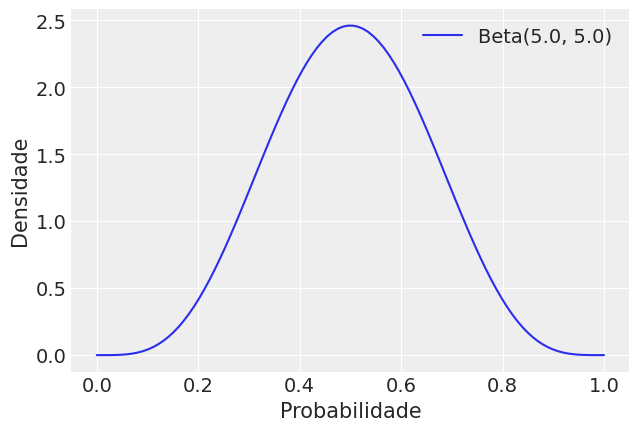

In [191]:
x_plot = np.linspace(0, 1, 100)
pbar = 0.5
theta = 10.0

plt.plot(
    x_plot,
    np.exp(pm.Beta.dist(pbar * theta, (1 - pbar) * theta).logp(x_plot).eval()),
    label=f"Beta({pbar * theta}, {(1 - pbar) * theta})",
)
plt.xlabel("Probabilidade")
plt.ylabel("Densidade")
plt.legend();

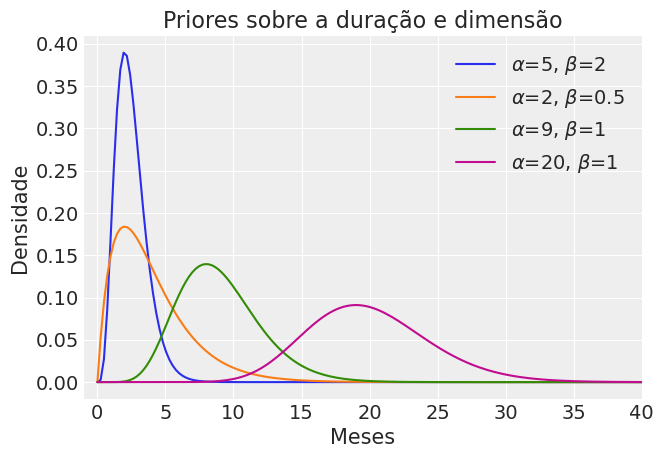

In [192]:
# collapse
x = np.linspace(0, 120, 500)
priors = [
    (r"$\alpha$=5, $\beta$=2", pm.Gamma.dist(alpha=5, beta=2)),
    (r"$\alpha$=2, $\beta$=0.5", pm.Gamma.dist(alpha=2, beta=0.5)),
    (r"$\alpha$=9, $\beta$=1", pm.Gamma.dist(alpha=9, beta=1)),
    (r"$\alpha$=20, $\beta$=1", pm.Gamma.dist(alpha=20, beta=1)),
]

fig = plt.figure()

for i, prior in enumerate(priors):
    plt.plot(x, np.exp(prior[1].logp(x).eval()), label=prior[0])

plt.xlim((-1, 40))
plt.xlabel("Meses")
plt.ylabel("Densidade")
plt.title("Priores sobre a duração e dimensão")
plt.legend();

In [216]:

amplitude_trend = pm.HalfNormal.dist(1.0).random(1)
ls_trend = pm.Gamma.dist(alpha=5, beta=2).random(1)

print("Amplitude da tendência: ", amplitude_trend)
print("Ls tendência: ", ls_trend)

# Define the true covariance function and its parameters
cov_trend = (amplitude_trend ** 2) * (pm.gp.cov.Matern52(1, ls_trend))

print("Cov da tendência: ", cov_trend)

n = 200  # The number of data points
# The inputs to the GP, they must be arranged as a column vector
prior_timepoints = np.linspace(0, 60, n)[:, None]  

K = cov_trend(prior_timepoints).eval()

gp_prior_samples = np.random.multivariate_normal(mean=np.zeros(K.shape[0]), cov=K, size=20_000)

Amplitude da tendência:  1.5272387337738265
Ls tendência:  5.983007758123174


ValueError: not enough values to unpack (expected 2, got 0)

In [20]:
# hide_inputs
_, (left, mid, right) = plt.subplots(
    1, 3, figsize=(14, 5), constrained_layout=True, sharex=True, sharey=True
)
for ax, samples in zip((left, mid, right), (5, 10, 100)):
    ax.plot(
        prior_timepoints,
        gp_prior_samples[:samples].T,
        color="darkblue",
        alpha=0.3,
    )
    ax.set_title("Samples from the GP prior")
    ax.set_xlabel("Time in months")
    ax.set_ylabel("Popularity evolution");
    

NameError: name 'prior_timepoints' is not defined

In [ ]:
# hide_input
_, ax = plt.subplots(1, 1, figsize=(14, 5))

ax.plot(
    prior_timepoints.flatten(), np.median(gp_prior_samples, axis=0), color="darkblue"
)
az.plot_hdi(
    prior_timepoints.flatten(),
    gp_prior_samples,
    hdi_prob=0.2,
    ax=ax,
    color="darkblue",
    fill_kwargs={"alpha": 0.4},
)
az.plot_hdi(
    prior_timepoints.flatten(),
    gp_prior_samples,
    hdi_prob=0.4,
    ax=ax,
    color="darkblue",
    fill_kwargs={"alpha": 0.3},
)
az.plot_hdi(
    prior_timepoints.flatten(),
    gp_prior_samples,
    hdi_prob=0.6,
    ax=ax,
    color="darkblue",
    fill_kwargs={"alpha": 0.2},
)
az.plot_hdi(
    prior_timepoints.flatten(),
    gp_prior_samples,
    hdi_prob=0.8,
    ax=ax,
    color="darkblue",
    fill_kwargs={"alpha": 0.1},
)

ax.set_title("Prior marginal quantiles from the GP")
ax.set_xlabel("Time in months")
ax.set_ylabel("Residual change in popularity");

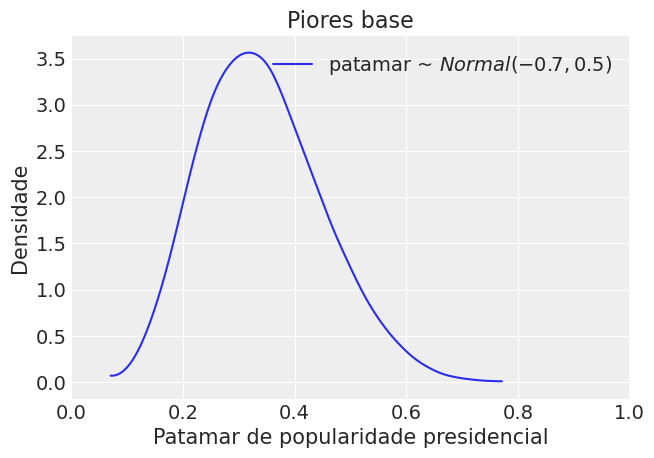

In [23]:
# hide_input
baseline_prior_samples = pm.Normal.dist(-0.7, 0.5).random(size=20_000)

ax = az.plot_kde(
    logistic(baseline_prior_samples),
    label="patamar ~ $Normal(-0.7, 0.5)$",
)
ax.set_xlim((0, 1))
ax.set_xlabel("Patamar de popularidade presidencial")
ax.set_ylabel("Densidade")
ax.set_title("Piores base");


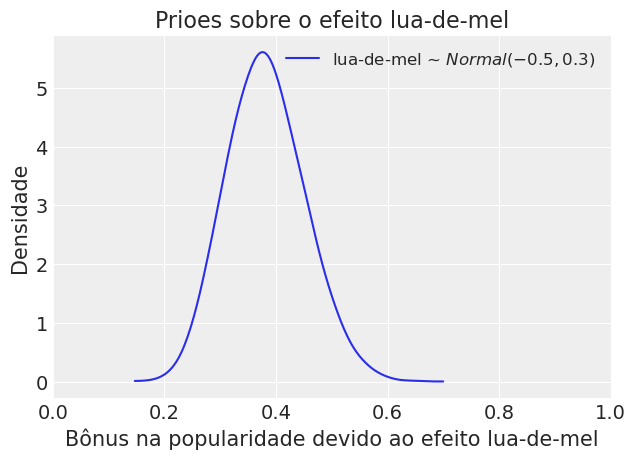

In [26]:
# hide_input
honeymoon_prior_samples = pm.Normal.dist(-0.5, 0.3).random(size=20_000)

ax = az.plot_kde(
    logistic(honeymoon_prior_samples),
    label="lua-de-mel ~ $Normal(-0.5, 0.3)$",
)
ax.set_xlim((0, 1))
ax.set_xlabel("Bônus na popularidade devido ao efeito lua-de-mel")
ax.set_ylabel("Densidade")
ax.set_title("Prioes sobre o efeito lua-de-mel")
ax.legend(fontsize=12);

In [27]:
unemp_effect_prior_samples = pm.Normal.dist(0.0, 0.2).random(size=20_000)
fake_unemp = np.linspace(-3, 3, 200)[None, :]

prior_approval = logistic(
    baseline_prior_samples[:, None]
    + gp_prior_samples
    + unemp_effect_prior_samples[:, None] * fake_unemp
)

NameError: name 'gp_prior_samples' is not defined

In [ ]:
# hide_input
_, (left, mid, right) = plt.subplots(
    1, 3, figsize=(16, 5), constrained_layout=True, sharex=True, sharey=True
)
for ax, samples in zip((left, mid, right), (5, 10, 100)):
    ax.plot(prior_timepoints, prior_approval[:samples].T, color="darkblue", alpha=0.3)
    ax.set_title("Prior pushforward checks")
    ax.set_xlabel("Time in months")
    ax.set_ylabel("Popularity evolution");

In [ ]:
# hide_input
_, ax = plt.subplots(1, 1, figsize=(14, 5))

ax.plot(prior_timepoints.flatten(), np.median(prior_approval, axis=0), color="darkblue")
az.plot_hdi(
    prior_timepoints.flatten(),
    prior_approval,
    hdi_prob=0.2,
    ax=ax,
    color="darkblue",
    fill_kwargs={"alpha": 0.4},
)
az.plot_hdi(
    prior_timepoints.flatten(),
    prior_approval,
    hdi_prob=0.4,
    ax=ax,
    color="darkblue",
    fill_kwargs={"alpha": 0.3},
)
az.plot_hdi(
    prior_timepoints.flatten(),
    prior_approval,
    hdi_prob=0.6,
    ax=ax,
    color="darkblue",
    fill_kwargs={"alpha": 0.2},
)
az.plot_hdi(
    prior_timepoints.flatten(),
    prior_approval,
    hdi_prob=0.8,
    ax=ax,
    color="darkblue",
    fill_kwargs={"alpha": 0.1},
)

ax.set_title("Prior pushforward marginal quantiles")
ax.set_xlabel("Time in months")
ax.set_ylabel("Popularity evolution");


In [23]:

import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, YearLocator, MonthLocator
plt.style.use('ggplot')

def plot(df, filename, heading=None):

    fig, ax = plt.subplots(figsize=(8, 4))

    min_date = None
    max_date = None
    for col_name in df.columns.values:

        # plot the column
        col = df[col_name]
        col = col[col.notnull()] # drop NAs
        dates = [zzz.to_timestamp().date() for zzz in col.index]
        ax.plot_date(x=dates, y=col, fmt='-', label=col_name,
            tz=None, xdate=True, ydate=False, linewidth=1.5)

        # establish the date range for the data
        if min_date:
            min_date = min(min_date, min(dates))
        else:
            min_date = min(dates)
        if max_date:
            max_date = max(max_date, max(dates))
        else:
            max_date = max(dates)

    # give a bit of space at each end of the plot - aesthetics
    span = max_date - min_date
    extra = int(span.days * 0.03) * datetime.timedelta(days=1)
    ax.set_xlim([min_date - extra, max_date + extra])

    # format the x tick marks
    ax.xaxis.set_major_formatter(DateFormatter('%Y'))
    ax.xaxis.set_minor_formatter(DateFormatter('\n%b'))
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator(bymonthday=1, interval=2))

    # grid, legend and yLabel
    ax.grid(True)
    ax.legend(loc='best', prop={'size':'x-small'})
    ax.set_ylabel('Percent')

    # heading
    if heading:
        fig.suptitle(heading, fontsize=12)
    fig.tight_layout(pad=1.5)

    # footnote
    fig.text(0.99, 0.01, 'marktheballot.blogspot.com.au', ha='right', 
        va='bottom', fontsize=8, color='#999999')

    # save to file
    fig.savefig(filename, dpi=125)


In [24]:


[1]: import numpy as np

In [2]: x = np.random.randn(100)

In [3]: y = x + np.random.randn(100) + 10

In [4]: import matplotlib.pyplot as plt

In [5]: fig, ax = plt.subplots(figsize=(8, 4))

In [6]: ax.scatter(x, y, alpha=0.5, color='orchid')
Out[6]: 

In [7]: fig.suptitle('Example Scatter Plot')
Out[7]: 

In [8]: fig.tight_layout(pad=2); 

In [9]: ax.grid(True)

In [10]: fig.savefig('filename1.png', dpi=125)

SyntaxError: invalid syntax (<ipython-input-24-0324ad0604c7>, line 1)

In [ ]:

That was easy. Next we will add a regression line. We will use the statsmodels package to calculate the regression line. Lines 11 to 15 is where we model the regression. Lines 16 to 20 we calculate and plot the regression line.

The key trick is at line 12: we need to add the intercept term explicitly. Without with this step, the regression model would be: y ~ x, rather than y ~ x + c. Similarly, at line 17, we include an intercept term in the data we provide to the predicting method at line 18. The sm.add_constant() method prepends a column of ones for the constant term in the regression model, returning a two column numpy array. The first column is ones, the second column is our original data from above. 


In [ ]:
In [11]: import statsmodels.api as sm

In [12]: x = sm.add_constant(x) # constant intercept term

In [13]: # Model: y ~ x + c

In [14]: model = sm.OLS(y, x)

In [15]: fitted = model.fit()

In [16]: x_pred = np.linspace(x.min(), x.max(), 50)

In [17]: x_pred2 = sm.add_constant(x_pred)

In [18]: y_pred = fitted.predict(x_pred2)

In [19]: ax.plot(x_pred, y_pred, '-', color='darkorchid', linewidth=2)
Out[19]: []

In [20]: fig.savefig('filename2.png', dpi=125)

In [ ]:
If we wanted key data from the regression, the following would do the job, after line 15:

print(fitted.params)     # the estimated parameters for the regression line
print(fitted.summary())  # summary statistics for the regression

We can add a confidence interval for the regression. There is a 95 per cent probability that the true regression line for the population lies within the confidence interval for our estimate of the regression line calculated from the sample data. We will calculate this from scratch, largely because I am not aware of a simple way of doing it within the statsmodels package.

To get the necessary t-statistic, I have imported the scipy stats package at line 27, and calculated the t-statistic at line 28.  

In [ ]:
y_hat = fitted.predict(x) # x is an array from line 12 above

In [23]: y_err = y - y_hat

In [24]: mean_x = x.T[1].mean()

In [25]: n = len(x)

In [26]: dof = n - fitted.df_model - 1

In [27]: from scipy import stats

In [28]: t = stats.t.ppf(1-0.025, df=dof)

In [29]: s_err = np.sum(np.power(y_err, 2))

In [30]: conf = t * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((x_pred-mean_x),2) / 
   ....:     ((np.sum(np.power(x_pred,2))) - n*(np.power(mean_x,2))))))

In [31]: upper = y_pred + abs(conf)

In [32]: lower = y_pred - abs(conf)

In [33]: ax.fill_between(x_pred, lower, upper, color='#888888', alpha=0.4)
Out[33]: 

In [34]: fig.savefig('filename3.png', dpi=125)

In [ ]:
In [35]: from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [36]: sdev, lower, upper = wls_prediction_std(fitted, exog=x_pred2, alpha=0.05)

In [37]: ax.fill_between(x_pred, lower, upper, color='#888888', alpha=0.1)
Out[37]: 

In [38]: fig.savefig('filename4.png', dpi=125)